# Lecture et écriture de fichiers NetCDF

## Imports nécessaires

In [17]:
from netCDF4 import Dataset
from netCDF4 import num2date
from netCDF4 import date2num
import datetime
import numpy as np
import os

## Ouvrir le fichier contenant les données

In [18]:
file_name = 'data1.nc'
nc = Dataset(file_name, 'r')

## Accès à la variable thetao

In [19]:
thetao = nc.variables['thetao']

## Connaitre le nombre de pas de temps

In [20]:
dim_size = nc.dimensions['time'].size

## Ouverture en écriture d'un nouveau fichier NetCDF

In [21]:
new_file_path = 'custom_netcdf.nc'
try:
    os.remove(new_file_path)
except :
    pass
new_netcdf_file = Dataset(new_file_path, "w")


## Créer une nouvelle dimension et une nouvelle variable pour stocker le temps

In [22]:
new_netcdf_file.createDimension("time", dim_size)
time = new_netcdf_file.createVariable("time", "f4", ("time",))

## Créer une variable associée à cette dimension

In [23]:
mean_temp = new_netcdf_file.createVariable("mean_temp", "f4", ("time",))

## Calculer toutes les températures moyennes et les stocker dans un tableau numpy

In [24]:
average_temp = []
for i, v in enumerate(nc['time']):
    # Récupérer les températures pour cette heure,
    # à la surface de l'océan (niveau d'index 0)
    # au niveau des côtés française (intervals de latitudes et de longitudes)
    data = np.asarray(thetao[i, 0, 50:150, 150:240], type(thetao))
    # Récupérer le masque représentant les données en mer
    idx = data != thetao._FillValue
    # Convertir les données en degrés celsius
    data = data[idx] * thetao.scale_factor + thetao.add_offset
    print np.mean(data)
    average_temp.append(np.mean(data))


18.5357846414
18.5120161096
18.488121642
18.4639173255
18.4396946618
18.416957247
18.3961044646
18.3774056526
18.3614875541
18.360365141
18.3647188767
18.3665938217
18.4006967149
18.4540390042
18.5023074639
18.5476717696
18.5885289563
18.6219911625
18.6069789792
18.5688878281
18.5467006848
18.5194216581
18.4928399748
18.4739469752


## Stocker les moyennes calculées dans la variable NetCDF

In [25]:
mean_temp[:] = average_temp

## Réchantillonage

* faire un rééchantillonnage tous les 3 points ("striding" - dégradation de résolution du 1/36° au 1/12°)
* calculer les moyennes à partir du rééchantillonage et comparer avec les moyennes calculées précédemment

In [28]:
error = []
for i, v in enumerate(nc['time']):
    # Récupérer les températures pour cette heure,
    # à la surface de l'océan
    # au niveau des côtés française avec un stride de 3
    data = np.asarray(thetao[i, 0, 50:150:3, 150:240:3], type(thetao))
    # Récupérer le masque mer
    sea_mask = data != thetao._FillValue
    # Convertir les données en degré celsuis
    data = data[sea_mask] * thetao.scale_factor + thetao.add_offset
    # Calculer la moyenne
    mean = np.mean(data)
    # Calculer la différence par rapport à la moyenne sans rééchantillonage
    error.append(np.abs(mean - mean_temp[i]))
print error
print(np.mean(error))
    

[0.0062724511452607601, 0.0061275740218356134, 0.0059165220012147302, 0.0056390982555818425, 0.005198166901884349, 0.0051782515787053285, 0.0052815642719252764, 0.0050016880852545853, 0.0043993702484712571, 0.0038728610591824975, 0.003346721581493739, 0.0030136862609815296, 0.0034232581581576937, 0.0045709529416697592, 0.0053036371685344363, 0.005352225425276913, 0.005124814532198485, 0.0054987622783606582, 0.0049507202077236911, 0.0045086131561191678, 0.0045302938357600908, 0.0040819469533879271, 0.0038881905166796571, 0.0036929506935230449]
0.00475726338663


## Récupérer le masque terre / mer

In [29]:
fill_value = thetao._FillValue
masque = np.asarray(thetao[:]) == fill_value

## Afficher le nombre de valeurs pour la terre

In [30]:
np.sum(masque)

22425744

## Créer un masque terre/mer

Créer un masque terre/mer dans lequel les valeurs sur terre sont à 1 et les valeurs en mer sont à 0

In [40]:
masque2 = np.ndarray(np.asarray(thetao[:]).shape)
masque2[masque] = 1
masque2.shape
new_netcdf_file
print nc

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.7.0 (http://mpimet.mpg.de/cdi)
    Conventions: CF-1.0
    source: IBI-MFC (PdE Production Center)
    institution: Puertos del Estado (PdE)
    nco_openmp_thread_number: 1
    title: Ocean 3D IBI hourly mean fields
    easting: longitude
    northing: latitude
    references: http://marine.copernicus.eu/
    domain_name: IBI36
    field_type: mean
    field_date: 20171004
    field_julian_date: 24748.f
    comment: Class1 metrics
    julian_day_unit: Hours since 1950-01-01 00:00:00
    forecast_range: 01-day_hindcast
    forecast_type: hindcast
    bulletin_date: 2017-10-05
    bulletin_type: Operational
    longitude_min: -7.5555553f
    longitude_max: -0.77756983f
    latitude_min: 43.305557f
    latitude_max: 48.27793f
    z_min: 0.49402538f
    z_max: 4833.2905f
    contact: mailto: servicedesk.cmems@mercator-ocean.eu
    netcdf_version_id: 4.4.

## Ajout des dimensions au nouveau fichier

### Ajout de la profondeur

In [41]:
new_netcdf_file.createDimension('depth', nc['deptht'].size)
depth = new_netcdf_file.createVariable('depth', 'f4', ('depth',))
depth = nc['deptht']


RuntimeError: NetCDF: String match to name in use

### Ajout de la longitude

In [38]:
new_netcdf_file.createDimension('longitude', nc['longitude'].size)
longitude = new_netcdf_file.createVariable('longitude', 'f4', ('longitude',))
longitude = nc['longitude']

### Ajout de la latitude

In [35]:
new_netcdf_file.createDimension('latitude', nc['latitude'].size)
latitude = new_netcdf_file.createVariable('latitude', 'f4', ('latitude',))
latitude = nc['latitude']

### Créer une nouvelle variable NetCDF pour le masque

In [39]:
masque_variable = new_netcdf_file.createVariable('masque','b',('time', 'depth', 'latitude', 'longitude'))

## Ajouter les données du masque

In [42]:
masque_variable[:] = masque2

In [43]:
new_netcdf_file

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(24), depth(48), latitude(180), longitude(245)
    variables(dimensions): float32 time(time), float32 mean_temp(time), float32 depth(depth), float32 latitude(latitude), float32 longitude(longitude), int8 masque(time,depth,latitude,longitude)
    groups: 

In [44]:
new_netcdf_file['masque']

<type 'netCDF4._netCDF4.Variable'>
int8 masque(time, depth, latitude, longitude)
unlimited dimensions: 
current shape = (24, 48, 180, 245)
filling on, default _FillValue of -127 ignored

## Refermer le fichier

In [45]:
new_netcdf_file.close()

## Convertir les dates en objets datetime 

In [46]:
for i, v in enumerate(nc['time']):
    datetime_object = num2date(v, nc['time'].units)
    print datetime_object.hour

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


## Afficher l'évolution de la température en fonction de la profondeur

### Calcul des températures moyennes par profondeur

In [54]:
# Initialisation d'un tableau temps / profondeur
average_temperature = np.ndarray([nc['time'].size, nc['deptht'].size])
for i_time, v_time in enumerate(nc['time']):
    for i_depth, v_depth in enumerate(nc['deptht']):
        # Récupérer les températures pour une heure et une profondeur données
        data = np.asarray(thetao[i_time, i_depth, :, :], type(thetao))
        # Récupérer le masque
        idx = data != thetao._FillValue
        # Convertir les données en degré celsius
        data = data[idx] * thetao.scale_factor + thetao.add_offset
        # Assignation de la moyenne pour une heure et une profondeur données
        average_temperature[i_time][i_depth] = np.mean(data)

## Tracé de la température en fonction de la profondeur pour la première échéance horaire

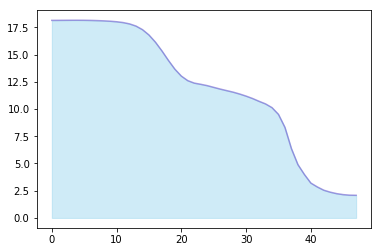

In [55]:
import matplotlib.pyplot as plt
x = range(nc['deptht'].size)
y = average_temperature[0, :]
plt.fill_between(x, y, color="skyblue", alpha=0.4)
plt.plot(x, y, color="Slateblue", alpha=0.6)
plt.show()